# Importing required libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.layers import Dense,Dropout
from keras.models import Sequential
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

# Importing data from csv

In [3]:
train_dataset = pd.read_csv('./train.csv')
test_dataset = pd.read_csv('./test.csv')
print(train_dataset.shape)
print(test_dataset.shape)

(891, 12)
(418, 11)


In [4]:
train_dataset.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_dataset.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
def outliers(df,features):
    indices = []
    for f in features:
        Q1 = np.percentile(df[f],25)
        Q3 = np.percentile(df[f],75)
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        outlier_list_col = df[(df[f] < Q1 - outlier_step) | (df[f] > Q3 + outlier_step)].index
        indices.extend(outlier_list_col)
    indices = Counter(indices)
    outliers = list(i for i, v in indices.items() if v > 2)
    return outliers

In [7]:
train_dataset = train_dataset.drop(outliers(train_dataset,["Age","SibSp","Parch","Fare"]),axis = 0).reset_index(drop = True)

Text(0.5, 1.0, 'Correlation Matrix')

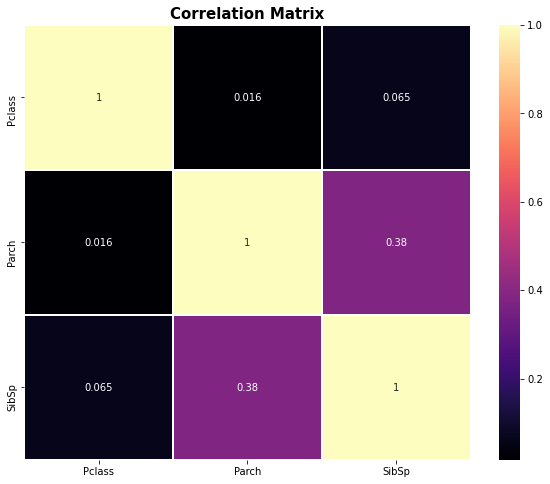

In [8]:
corr_matrix=train_dataset[['Pclass','Parch','Embarked','Sex','SibSp']].corr()
fig,axis=plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True,ax=axis,cmap="magma",linewidth=.5,linecolor='white')
axis.set_title('Correlation Matrix',fontweight='semibold',fontsize=15)

# Spliting independant and dependant variables

In [9]:
X_train = train_dataset.iloc[:, [2,4,5,6,7,9,11]].values
y_train = train_dataset.iloc[:, 1].values
X_train.shape

(881, 7)

# Converting test data into numpy array

In [10]:
X_test = test_dataset.iloc[:, [1,3,4,5,6,8,10]].values

# Preprocessing data

## Converting Gender from categorical to binary variable

In [11]:
label_encoder_gender = LabelEncoder()
X_train[:, 1] = label_encoder_gender.fit_transform(X_train[:, 1])
X_test[:, 1] = label_encoder_gender.transform(X_test[:, 1])

## Filling missing values of emarked with mode

In [12]:
most_frequent_embarked = max(dict(train_dataset.Embarked.value_counts()))
# for training data
filling_indices = [x for x in range(len(X_train)) if X_train[x, -1] != 'S' and X_train[x, -1] != 'Q' and X_train[x, -1] != 'C']
X_train[filling_indices, -1] = most_frequent_embarked 

# for testing data
filling_indices = [x for x in range(len(X_test)) if X_test[x, -1] != 'S' and X_test[x, -1] != 'Q' and X_test[x, -1] != 'C']
X_test[filling_indices, -1] = most_frequent_embarked

## Filling missing age values with mean age

In [13]:
imputer_age = SimpleImputer(strategy='mean')
X_train[:, [2]] = imputer_age.fit_transform(X_train[:, [2]])
X_test[:, [2]] = imputer_age.transform(X_test[:, [2]])

## Filling missing fare values with mean

In [14]:
imputer_fare = SimpleImputer(strategy='mean')
X_train[:, [5]] = imputer_fare.fit_transform(X_train[:, [5]])
X_test[:, [5]] = imputer_fare.transform(X_test[:, [5]])

## OneHot encoding passenger class

In [15]:
ct_pclass = ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories='auto'), [0])],remainder='passthrough')
X_train = ct_pclass.fit_transform(X_train)
X_test = ct_pclass.transform(X_test)

## Skipping dummy variable trap

In [16]:
X_train = X_train[:, 1:]
X_test = X_test[:, 1:]

## Converting embarked location to sparse matrix

In [17]:
embarked_encoder = LabelEncoder()
X_train[:, -1] = embarked_encoder.fit_transform(X_train[:, -1])
X_test[:, -1] = embarked_encoder.transform(X_test[:, -1])

## Applying z-score normalization to age

In [18]:
sc_age = StandardScaler()
X_train[:, [5]] = sc_age.fit_transform(X_train[:, [5]])
X_test[:, [5]] = sc_age.transform(X_test[:, [5]])

## Applying z-score normalization to fare

In [19]:
sc_fare = StandardScaler()
X_train[:, [-1]] = sc_fare.fit_transform(X_train[:, [-1]])
X_test[:, [-1]] = sc_fare.transform(X_test[:, [-1]])
X_train.shape

(881, 8)

## Applying PCA for feature reduction

In [20]:
pca = PCA(n_components=8)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_train.shape

(881, 8)

# Applying NAIVE BAYES CLASSIFIER to predict survival

In [21]:
bayes_classifier = GaussianNB()
bayes_classifier.fit(X_train[50:], y_train[50:])

GaussianNB()

# Model's predictions

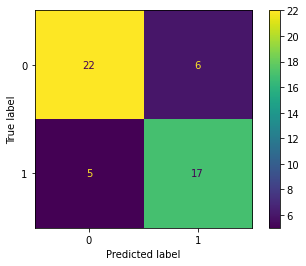

In [24]:
bayes_predictions = bayes_classifier.predict(X_train[:50])
plot_confusion_matrix(bayes_classifier, X_train[:50], y_train[:50])  
acc_bayes = round(bayes_classifier.score(X_train[:50], y_train[:50]) * 100, 2)


In [25]:
#print("Not survived : {}  ".format(sum(bayes_predictions==0)),
#      "Survived : {}".format(sum(bayes_predictions==1)))
acc_bayes

78.0

# Applying SVM 

In [198]:
from sklearn.svm import SVC, LinearSVC

In [28]:
svc = LinearSVC()
svc.fit(X_train[50:], y_train[50:])
Y_pred_svm = svc.predict(X_test)
acc_linear_svc = round(svc.score(X_train[:50], y_train[:50]) * 100, 2)


c:\users\ahsan\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of SVM :72.0
Predictions on the Test Set
[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1
 1 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0
 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]


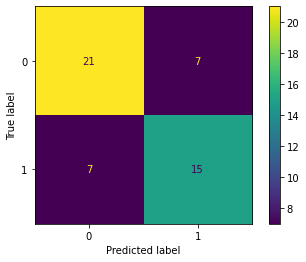

In [30]:
print("Accuracy of SVM :{}".format(acc_linear_svc))
print("Predictions on the Test Set")
print(Y_pred_svm)
plot_confusion_matrix(svc, X_train[:50], y_train[:50])  


# Applying Logistic Regression

In [206]:
from sklearn.linear_model import LogisticRegression

In [31]:
logreg = LogisticRegression()
logreg.fit(X_train[50:], y_train[50:])
Y_pred_log = logreg.predict(X_test)
acc_log = round(logreg.score(X_train[:50], y_train[:50]) * 100, 2)

c:\users\ahsan\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of Logistic Regression :76.0
Predictions on the Test Set
[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


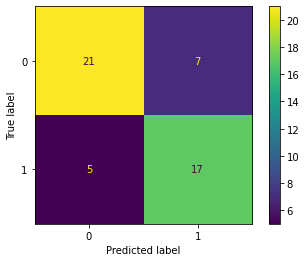

In [32]:
print("Accuracy of Logistic Regression :{}".format(acc_log))
print("Predictions on the Test Set")
print(Y_pred_log)
plot_confusion_matrix(logreg, X_train[:50], y_train[:50])  


# Applying Decision Tree

In [212]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train[50:], y_train[50:])
Y_pred_dt = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train[:50], y_train[:50]) * 100, 2)


Accuracy of Decision Tree :66.0
Predictions on the Test Set
[0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0
 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1
 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0
 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0
 0 1 1 1 1 0 0 1 0 0 1]


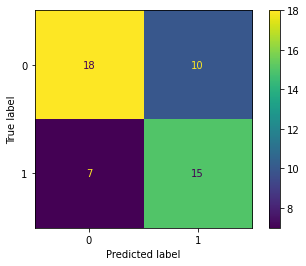

In [35]:
print("Accuracy of Decision Tree :{}".format(acc_decision_tree))
print("Predictions on the Test Set")
plot_confusion_matrix(decision_tree, X_train[:50], y_train[:50])  

print(Y_pred_dt)

# Applying Random Forest 

In [218]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rf_classifier = RandomForestClassifier(n_estimators = 25)
rf_classifier.fit(X_train[50:], y_train[50:])
rf_predictions = rf_classifier.predict(X_test)
acc_random_forest = round(rf_classifier.score(X_train[:50], y_train[:50]) * 100, 2)

Accuracy of Decision Tree :64.0
Predictions on the Test Set
[0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0
 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]


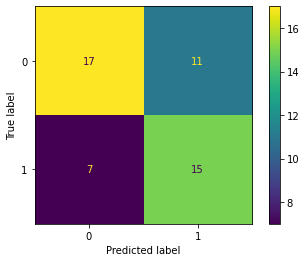

In [37]:
print("Accuracy of Decision Tree :{}".format(acc_random_forest))
print("Predictions on the Test Set")
plot_confusion_matrix(rf_classifier, X_train[:50], y_train[:50])  

print(rf_predictions)

# Applying Neural Network to Data

In [26]:
from keras.layers import Dense,Dropout
from keras.models import Sequential

In [27]:

y_train.shape
X_train.shape


(881, 8)

In [39]:
Model = Sequential()
Model.add(Dense(16,input_dim=(8),activation='relu'))
Model.add(Dense(1,activation='sigmoid'))

In [40]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [41]:
Model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [42]:
history=Model.fit(X_train[50:],y_train[50:],epochs=52,batch_size=32)

Epoch 1/52
26/26 [==============================] - 0s 678us/step - loss: 2.5359 - accuracy: 0.3758
Epoch 2/52
26/26 [==============================] - 0s 667us/step - loss: 1.5383 - accuracy: 0.4105
Epoch 3/52
26/26 [==============================] - 0s 917us/step - loss: 0.8882 - accuracy: 0.6528
Epoch 4/52
26/26 [==============================] - 0s 737us/step - loss: 0.7577 - accuracy: 0.7020
Epoch 5/52
26/26 [==============================] - 0s 798us/step - loss: 0.5926 - accuracy: 0.6944
Epoch 6/52
26/26 [==============================] - 0s 798us/step - loss: 0.5770 - accuracy: 0.6904
Epoch 7/52
26/26 [==============================] - 0s 837us/step - loss: 0.5567 - accuracy: 0.7189
Epoch 8/52
26/26 [==============================] - 0s 796us/step - loss: 0.5526 - accuracy: 0.7187
Epoch 9/52
26/26 [==============================] - 0s 758us/step - loss: 0.5407 - accuracy: 0.7248
Epoch 10/52
26/26 [==============================] - 0s 758us/step - loss: 0.5457 - accuracy: 0.7013

In [55]:
eval_1=Model.evaluate(X_train[:50],y_train[:50])

2/2 [==============================] - 0s 2ms/step - loss: 0.5022 - accuracy: 0.8000


In [47]:
Prediction=Model.predict_classes(X_train[:50])
print(Prediction)


[[0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]]


In [199]:
Model.save('./Good_Model2.h5')

In [45]:
plot_confusion_matrix(Model, X_train[:50], y_train[:50])  


ValueError: plot_confusion_matrix only supports classifiers

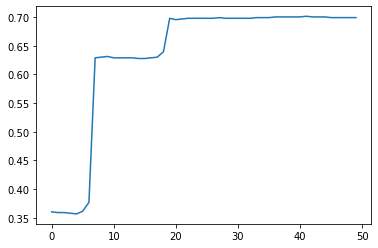

In [149]:
plt.plot(history.history['accuracy'])

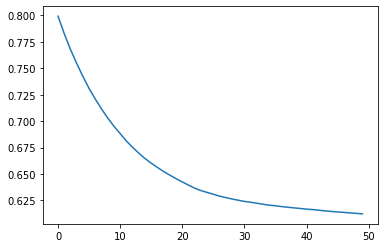

In [150]:
plt.plot(history.history['loss'])

In [48]:
from sklearn.metrics import confusion_matrix


In [49]:
cm=confusion_matrix(y_train[:50],Prediction)

c:\users\ahsan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
c:\users\ahsan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


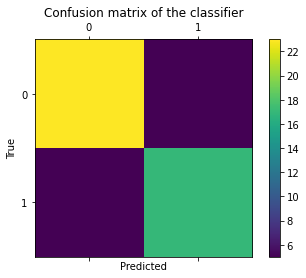

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + ['0','1'])
ax.set_yticklabels([''] + ['0','1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

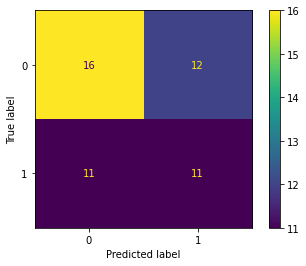

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors = 3)
knn_classifier.fit(X_train[50:], y_train[50:])
knn_predictions = knn_classifier.predict(X_train[:50])
plot_confusion_matrix(knn_classifier, X_train[:50], y_train[:50])  
acc_knn = round(knn_classifier.score(X_train[:50], y_train[:50]) * 100, 2)


In [54]:
acc_knn

54.0

In [60]:
 models = pd.DataFrame({  
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Linear SVC', 
              'Decision Tree','Neural Network'],
    'Score': [acc_knn,acc_log,acc_random_forest,acc_bayes,acc_linear_svc,acc_decision_tree,(eval_1[1]*100)+2]})
sorted_model=models.sort_values(by='Score', ascending=False)
sorted_model

,Model,Score
6,Neural Network,82.000001
3,Naive Bayes,78.000000
1,Logistic Regression,76.000000
4,Linear SVC,72.000000
5,Decision Tree,66.000000
2,Random Forest,64.000000
0,KNN,54.000000
